In [69]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import models, layers, optimizers, backend, callbacks
from sklearn import ensemble
from sklearn import linear_model

import zillow

%matplotlib inline
from IPython.core.pylabtools import figsize
from seaborn import plt

# Load and Inspect Data

In [70]:
df = zillow.LoadTabularData("data/")

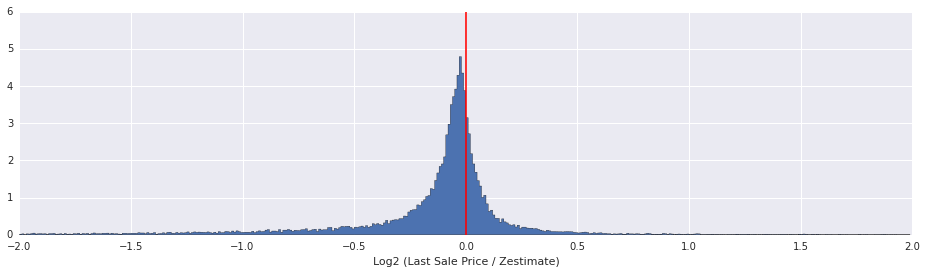

In [71]:
figsize(16, 4)
plt.hist(
    df.log_sold_to_zestimate, bins=np.arange(-2, 2, 0.01),
    histtype="stepfilled", normed=True)
plt.vlines(0, 0, 6, edgecolor="red", alpha=0.9)
plt.xlabel("Log2 (Last Sale Price / Zestimate)")
plt.show()

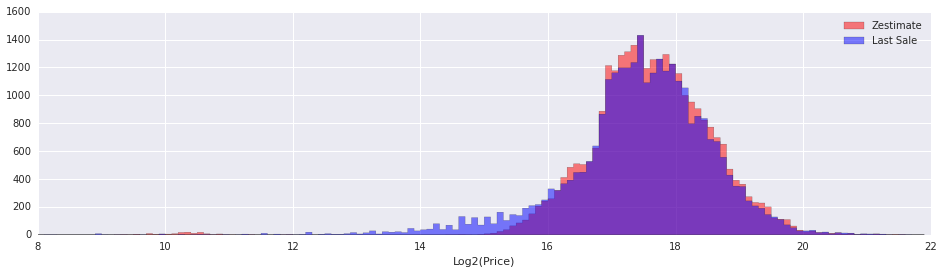

In [72]:
figsize(16, 4)
plt.hist(
    np.log2(df.zestimate), bins=np.arange(8, 22, 0.1),
    color="red", alpha=0.5, histtype="stepfilled", label="Zestimate")
plt.hist(
    np.log2(df.last_sold), bins=np.arange(8, 22, 0.1),
    color="blue", alpha=0.5, histtype="stepfilled", label="Last Sale")
plt.xlabel("Log2(Price)")
plt.legend()
plt.show()

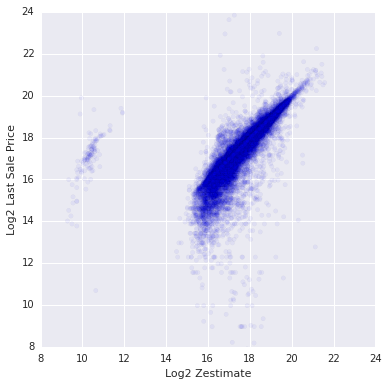

In [76]:
figsize(6, 6)
plt.scatter(np.log2(df.zestimate), np.log2(df.last_sold), alpha=0.05)
plt.xlabel("Log2 Zestimate")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.show()

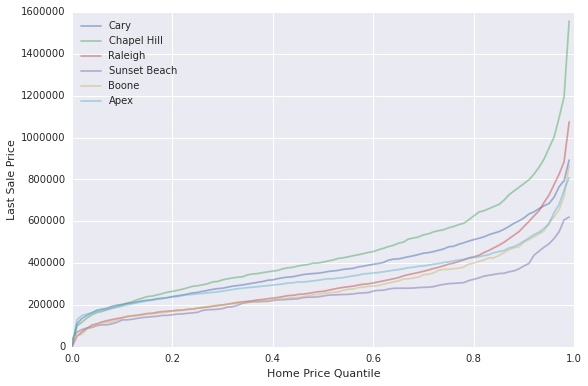

In [78]:
QUANTILES = np.arange(0, 1, 0.01)

def GetSaleQuantilesForCity(city):
    return df[df.city == city].last_sold.quantile(QUANTILES)

figsize(9, 6)
for city in ("Cary", "Chapel Hill", "Raleigh", "Sunset Beach", "Boone", "Apex"):
    plt.plot(
        QUANTILES, GetSaleQuantilesForCity(city),
        label=city, alpha=0.5)
plt.legend(loc="upper left")
plt.xlabel("Home Price Quantile")
plt.ylabel("Last Sale Price")
plt.show()

# Prepare Data for Training

In [79]:
df["region"] = df.city + df.state + df.zip.astype(str)
region_encoder = dict((r, n) for n, r in enumerate(df.region.unique()))
df["region_code"] = df.region.map(lambda r: region_encoder[r])

In [80]:
ixs = np.arange(df.shape[0])
np.random.shuffle(ixs)
n_test = int(df.shape[0] / 10)
test_ixs = ixs[:n_test]
train_ixs = ixs[n_test:]
test_df = df.iloc[test_ixs]
train_df = df.iloc[train_ixs]

# Traditional ML & Statistical Models Trained on Home Facts

### Vectorize Regions and Home Facts
We create a vector of sparse binary features, each corresponding to either a region (city + state + zip) or a common property of homes.

In [82]:
vectorizer, vf = zillow.VectorizeFacts(df.region.map(lambda r: [r]) + df.facts)
vf.shape

(29274, 1011)

### Random Forest Regression

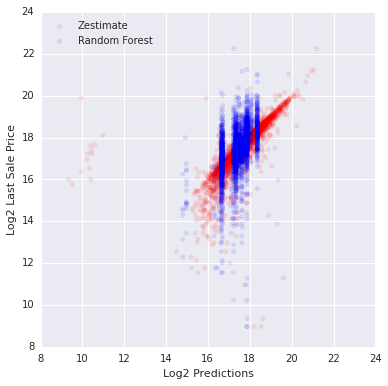

In [83]:
rfr = ensemble.RandomForestRegressor(n_estimators=100, max_leaf_nodes=10, n_jobs=-1)
rfr.fit(vf[train_ixs], np.log2(df.last_sold[train_ixs]))

rfr_preds = rfr.predict(vf[test_ixs])

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    rfr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Random Forest", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

### Ordinary Least Squares Regression

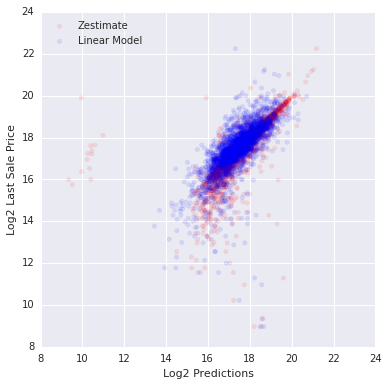

In [231]:
olsr = linear_model.LinearRegression(n_jobs=-1)
olsr.fit(vf[train_ixs], np.log2(df.last_sold[train_ixs]))

olsr_preds = olsr.predict(vf[test_ixs])

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    olsr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Linear Model", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

### Ridge Regression

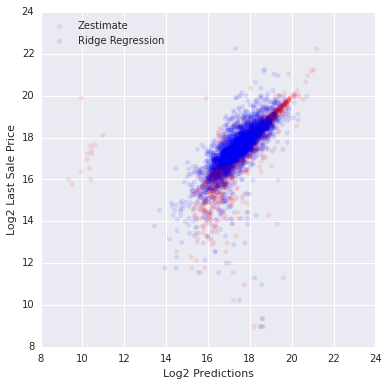

In [85]:
rr = linear_model.Ridge()
rr.fit(vf[train_ixs], np.log2(train_df.last_sold))

rr_preds = rr.predict(vf[test_ixs])

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    rr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Ridge Regression", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

# Deep Learning Models

### Multi-Layer Dense Network

In [86]:
def FactRegressor(n_facts, hidden_sizes=[100, 50, 20], nonlin=layers.advanced_activations.ELU):
    model = models.Sequential()
    sizes = [n_facts] + hidden_sizes + [1]
    for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:])):
        if i > 0 and i < len(sizes) - 1:
            model.add(layers.Dropout(0.5))
        model.add(layers.Dense(out_size, input_dim=in_size))
        model.add(nonlin())
    return model

In [130]:
fr = FactRegressor(vf.shape[1], hidden_sizes=[256, 128, 64, 32, 16])

In [131]:
fr.compile(optimizer="adam", loss="mse")

In [132]:
fr_history = fr.fit(
    vf[train_ixs],
    np.array(np.log2(train_df.last_sold)),
    batch_size=128,
    nb_epoch=200,
    verbose=0,
    validation_data=(
        vf[test_ixs],
        np.array(np.log2(test_df.last_sold))),
    shuffle=True,
    callbacks=[callbacks.LearningRateScheduler(
        lambda ep: 0.001 if ep < 100 else 0.0001)])

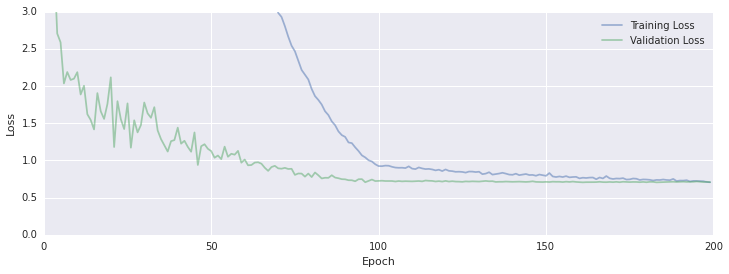

In [143]:
figsize(12, 4)
plt.plot(
    np.arange(200), fr_history.history["loss"],
    alpha=0.5, label="Training Loss")
plt.plot(
    np.arange(200), fr_history.history["val_loss"],
    alpha=0.5, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 3)
plt.show()

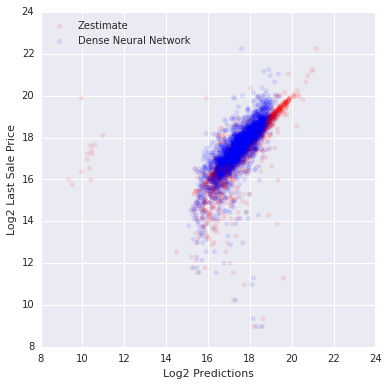

In [133]:
fr_preds = fr.predict(vf[test_ixs]).reshape((test_df.shape[0],))

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    fr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Dense Neural Network", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

### Deanse Network with Regional Scale and Attention Mechanism
I hypothesize that different properties are given different weight in different regions. We'll break our feature vector up into two parts: first, binary features for home properties; and second, region embeddings.

The final output will be the sum of a regional bias, and home desirability value multiplied by a regional scale value.

Regional bias and scale will be learned from the region embeddings alone. Home desirability will be learned from home properties, as filtered through an attention matrix learned from the region embeddings.

```
█████████████████████            █████████████████████
█ region_embeddings █            █ binary_properties █
█████████████████████            █████████████████████
      |\__      \____________             *
      |   \__                \---- attention_matrix
      |      \__                          =
      |         \__                     hidden
      |            \                      |                █████████
regional_bias  +  (regional_scale  *  home_desirability) = █ price █
                                                           █████████
                                                           ```

In [95]:
# Binary vectorization of properties only, without regions
_, vp = zillow.VectorizeFacts(df.facts)
vp.shape

(29274, 903)

In [96]:
def AttentiveRegressor(
        n_regions, n_facts,
        region_embedding_size=16,
        hidden_sizes=[128, 64, 32, 16],
        nonlin=layers.advanced_activations.ELU):
    # Embeddings
    embed = models.Sequential()
    embed.add(layers.embeddings.Embedding(n_regions, region_embedding_size, input_length=1))
    embed.add(layers.Reshape((region_embedding_size,)))
    embed.add(layers.Dropout(0.5))

    # Regional Mean
    reg_bias = models.Sequential()
    reg_bias.add(embed)
    reg_bias.add(layers.Dense(1))
    reg_bias.add(layers.Activation("relu"))
    reg_bias.add(layers.Lambda(lambda x: x + 1.0))

    # Regional Scale
    reg_scale = models.Sequential()
    reg_scale.add(embed)
    reg_scale.add(layers.Dense(1))
    reg_scale.add(layers.Activation("relu"))
    reg_scale.add(layers.Lambda(lambda x: x + 0.1))

    # Properties
    props = models.Sequential()
    props.add(layers.Reshape((n_facts,), input_shape=(n_facts,)))

    # Attention
    att = models.Sequential()
    att.add(embed)
    att.add(layers.Dense(n_facts))
    att.add(layers.Activation("sigmoid"))
    att_output = layers.Merge([att, props], mode="mul")

    # Home Desirability
    desire = models.Sequential()
    desire.add(att_output)
    sizes = [n_facts] + hidden_sizes + [1]
    for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:])):
        if i > 0 and i < len(sizes) - 1:
            desire.add(layers.Dropout(0.5))
        desire.add(layers.Dense(out_size, input_dim=in_size))
        if i < len(sizes) - 1:
            desire.add(nonlin())
        else:
            desire.add(layers.Activation("relu"))
            desire.add(layers.Lambda(lambda x: x + 1.0))

    # Output
    scale_x_desirability = layers.Merge([reg_scale, desire], mode="mul")
    raw_output = layers.Merge([reg_bias, scale_x_desirability], mode="sum")
    out = models.Sequential()
    out.add(raw_output)
    out.add(layers.Lambda(lambda x: tf.log(tf.maximum(x, 0.00001)) / np.log(2)))
    return out

In [120]:
ar = AttentiveRegressor(
    len(df.region.unique()), vp.shape[1],
    hidden_sizes=[256, 128, 64, 32, 16])

In [121]:
ar.compile(optimizer="adam", loss="mse")

In [122]:
ar_history = ar.fit(
    [train_df.region_code, vp[train_ixs]],
    np.array(np.log2(train_df.last_sold)),
    batch_size=128,
    nb_epoch=200,
    verbose=0,
    validation_data=(
        [test_df.region_code, vp[test_ixs]],
        np.array(np.log2(test_df.last_sold))),
    shuffle=True,
    callbacks=[callbacks.LearningRateScheduler(
        lambda ep: 0.001 if ep < 100 else 0.0001)])

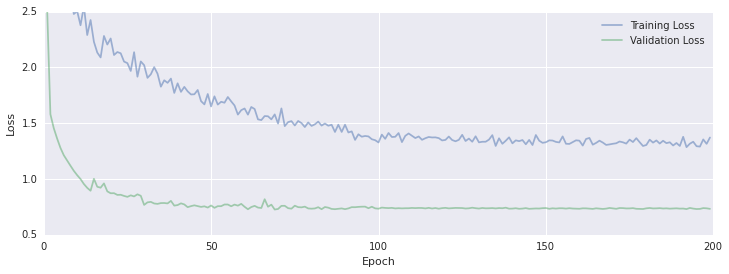

In [151]:
figsize(12, 4)
plt.plot(
    np.arange(200), ar_history.history["loss"],
    alpha=0.5, label="Training Loss")
plt.plot(
    np.arange(200), ar_history.history["val_loss"],
    alpha=0.5, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0.5, 2.5)
plt.show()

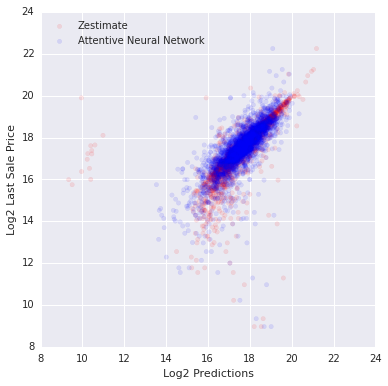

In [123]:
ar_preds = ar.predict([test_df.region_code, vp[test_ixs]]).reshape((test_df.shape[0],))

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    ar_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Attentive Neural Network", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

### Deanse Network with Regional Scale but No Attention Mechanism
Maybe the regional bias and scale are useful, but the attention mechanism is not? Architecture of the "inattentive network":

```
█████████████████████            █████████████████████
█ region_embeddings █            █ binary_properties █
█████████████████████            █████████████████████
      |\__                                |
      |   \__                             |
      |      \__                        hidden
      |         \__                       |
      |            \                      |                █████████
regional_bias  +  (regional_scale  *  home_desirability) = █ price █
                                                           █████████
                                                           ```

In [124]:
def InattentiveRegressor(
        n_regions, n_facts,
        region_embedding_size=16,
        hidden_sizes=[128, 64, 32, 16],
        nonlin=layers.advanced_activations.ELU):
    # Embeddings
    embed = models.Sequential()
    embed.add(layers.embeddings.Embedding(n_regions, region_embedding_size, input_length=1))
    embed.add(layers.Reshape((region_embedding_size,)))
    embed.add(layers.Dropout(0.5))

    # Regional Mean
    reg_bias = models.Sequential()
    reg_bias.add(embed)
    reg_bias.add(layers.Dense(1))
    reg_bias.add(layers.Activation("relu"))
    reg_bias.add(layers.Lambda(lambda x: x + 1.0))

    # Regional Scale
    reg_scale = models.Sequential()
    reg_scale.add(embed)
    reg_scale.add(layers.Dense(1))
    reg_scale.add(layers.Activation("relu"))
    reg_scale.add(layers.Lambda(lambda x: x + 0.1))

    # Properties
    props = models.Sequential()
    sizes = [n_facts] + hidden_sizes + [1]
    for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:])):
        if i > 0 and i < len(sizes) - 1:
            props.add(layers.Dropout(0.5))
        props.add(layers.Dense(out_size, input_dim=in_size))
        if i < len(sizes) - 1:
            props.add(nonlin())
        else:
            props.add(layers.Activation("relu"))
            props.add(layers.Lambda(lambda x: x + 1.0))

    # Output
    scale_x_desirability = layers.Merge([reg_scale, props], mode="mul")
    raw_output = layers.Merge([reg_bias, scale_x_desirability], mode="sum")
    out = models.Sequential()
    out.add(raw_output)
    out.add(layers.Lambda(lambda x: tf.log(tf.maximum(x, 0.00001)) / np.log(2)))
    return out

In [125]:
iar = InattentiveRegressor(
    len(df.region.unique()), vp.shape[1],
    hidden_sizes=[256, 128, 64, 32, 16])

In [126]:
iar.compile(optimizer="adam", loss="mse")

In [127]:
iar_history = iar.fit(
    [train_df.region_code, vp[train_ixs]],
    np.array(np.log2(train_df.last_sold)),
    batch_size=128,
    nb_epoch=200,
    verbose=0,
    validation_data=(
        [test_df.region_code, vp[test_ixs]],
        np.array(np.log2(test_df.last_sold))),
    shuffle=True,
    callbacks=[callbacks.LearningRateScheduler(
        lambda ep: 0.001 if ep < 100 else 0.0001)])

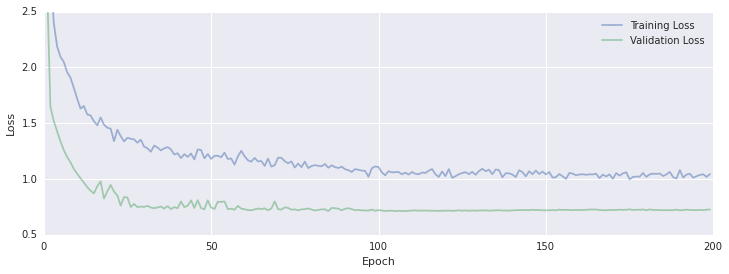

In [149]:
figsize(12, 4)
plt.plot(
    np.arange(200), iar_history.history["loss"],
    alpha=0.5, label="Training Loss")
plt.plot(
    np.arange(200), iar_history.history["val_loss"],
    alpha=0.5, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0.5, 2.5)
plt.show()

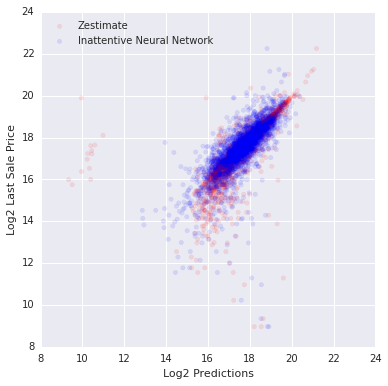

In [128]:
iar_preds = iar.predict([test_df.region_code, vp[test_ixs]]).reshape((test_df.shape[0],))

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    iar_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Inattentive Neural Network", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

### Deanse Network with Floor Size Scale
Maybe what we should really be predicting is cost per square foot! Assume that each feature of the home (including zip code) can either contribute a flat amount to the value of the house, or make each square foot of house more valubale.

```
   █████████
   █ facts █
   █████████
    ___|___
   /       \              ██████████████     █████████
bonus + (value_per_sqft * █ floor_size █ ) = █ price █
                          ██████████████     █████████
```

In [247]:
df["floor_size"], df["lot_size"] = zip(*df.facts.map(zillow.FloorAndLotSize))

In [270]:
def CostPerSquareFootRegressor(
        n_facts,
        hidden_sizes=[128, 64, 32, 16],
        nonlin=layers.advanced_activations.ELU):
    hidden = models.Sequential()
    sizes = [n_facts] + hidden_sizes
    for i, (in_size, out_size) in enumerate(zip(sizes[:-1], sizes[1:])):
        if i > 0:
            hidden.add(layers.Dropout(0.5))
        hidden.add(layers.Dense(out_size, input_dim=in_size))
        hidden.add(nonlin())

    # Un-scaled bonus, restricted to $0-$100k
    bonus = models.Sequential()
    bonus.add(hidden)
    bonus.add(layers.Dropout(0.5))
    bonus.add(layers.Dense(1))
    bonus.add(layers.Activation("sigmoid"))
    bonus.add(layers.Lambda(lambda x: x * 100 * 1000))

    # Cost per Squre Foot Multiplier
    multiplier = models.Sequential()
    multiplier.add(hidden)
    multiplier.add(layers.Dropout(0.5))
    multiplier.add(layers.Dense(1))
    multiplier.add(layers.Activation("relu"))

    # Floor size
    sqft = models.Sequential()
    sqft.add(layers.Reshape((1,), input_shape=(1,)))

    # Output
    sqft_x_multiplier = layers.Merge([sqft, multiplier], mode="mul")
    raw_output = layers.Merge([bonus, sqft_x_multiplier], mode="sum")
    out = models.Sequential()
    out.add(raw_output)
    out.add(layers.Lambda(lambda x: tf.log(tf.maximum(x, 0.00001)) / np.log(2)))
    return out

In [275]:
cpsfr = CostPerSquareFootRegressor(
    vf.shape[1],
    hidden_sizes=[256, 128, 64, 32, 16])

In [276]:
cpsfr.compile(optimizer="adam", loss="mse")

In [277]:
cpsfr_history = cpsfr.fit(
    [vf[train_ixs], df.floor_size[train_ixs]],
    np.array(np.log2(train_df.last_sold)),
    batch_size=128,
    nb_epoch=50,
    verbose=0,
    validation_data=(
        [vf[test_ixs], df.floor_size[test_ixs]],
        np.array(np.log2(test_df.last_sold))),
    shuffle=True,
    callbacks=[callbacks.LearningRateScheduler(
        lambda ep: 0.001 if ep < 20 else 0.0001)])

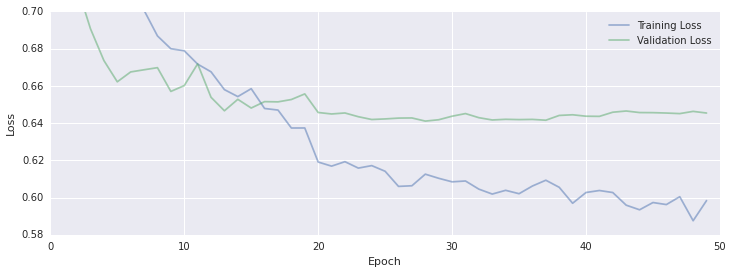

In [290]:
figsize(12, 4)
plt.plot(
    np.arange(50), cpsfr_history.history["loss"],
    alpha=0.5, label="Training Loss")
plt.plot(
    np.arange(50), cpsfr_history.history["val_loss"],
    alpha=0.5, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0.58, 0.70)
plt.show()

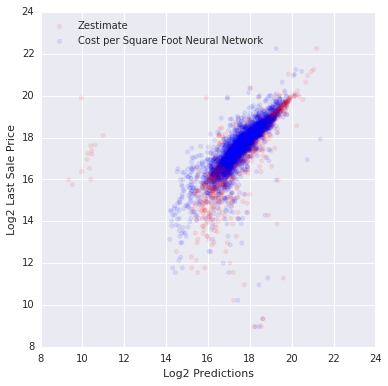

In [279]:
cpsfr_preds = cpsfr.predict(
    [vf[test_ixs], df.floor_size[test_ixs]]).reshape((test_df.shape[0],))

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    cpsfr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Cost per Square Foot Neural Network", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

# Model Results Comparison

In [280]:
model_names = [
    "zestimate",
    "dense network", "attentive network", "inattentive network",
    "cost per sqft network",
    "ridge regression", "linear regression", "random forest regression"]
log2_preds_by_model = [
    np.log2(test_df.zestimate),
    fr_preds, ar_preds, iar_preds,
    cpsfr_preds,
    rr_preds, olsr_preds, rfr_preds]
preds_by_model = [np.exp2(preds) for preds in log2_preds_by_model]
targets = test_df.last_sold
log2_targets = np.log2(targets)
results_df = pd.DataFrame({
    "model": model_names,
    "mean abs log2 err": [
        (preds - log2_targets).abs().mean()
        for preds in log2_preds_by_model],
    "mean abs error": [
        (preds - targets).abs().mean()
        for preds in preds_by_model],
    "median abs error": [
        (preds - targets).abs().median()
        for preds in preds_by_model],
    "median error %": [
        round(((preds - targets) / targets).abs().median() * 100, 2)
        for preds in preds_by_model]})
results_df.sort_values("mean abs error")

,mean abs error,mean abs log2 err,median abs error,median error %,model
0,41755.847967,0.330889,14158.000000,6.56,zestimate
4,64119.421056,0.422549,31541.234375,16.96,cost per sqft network
1,74730.458662,0.480979,37275.621094,20.62,dense network
2,77889.213595,0.493650,41082.343750,23.26,attentive network
3,78879.918749,0.494571,43054.656250,23.45,inattentive network
5,82093.354829,0.517441,41664.881956,23.62,ridge regression
6,82234.328177,0.517977,41936.792204,23.69,linear regression
7,107319.779593,0.713248,61222.206323,34.27,random forest regression


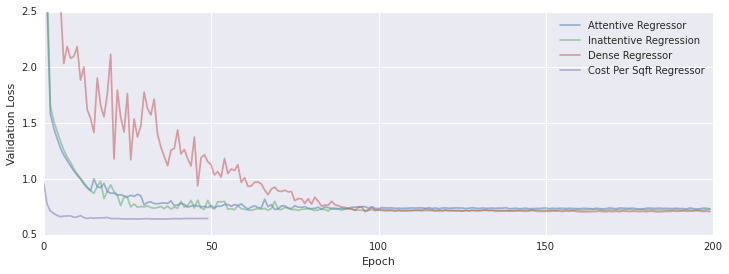

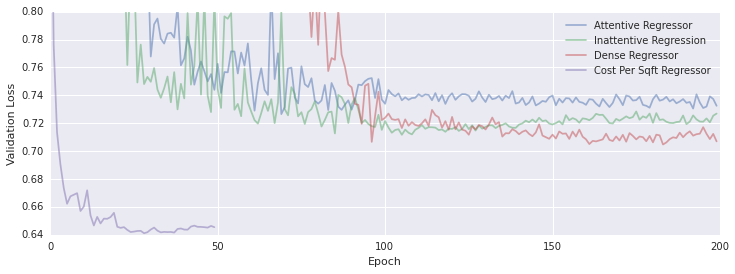

In [282]:
figsize(12, 4)
plt.plot(
    np.arange(200), ar_history.history["val_loss"],
    alpha=0.5, label="Attentive Regressor")
plt.plot(
    np.arange(200), iar_history.history["val_loss"],
    alpha=0.5, label="Inattentive Regression")
plt.plot(
    np.arange(200), fr_history.history["val_loss"],
    alpha=0.5, label="Dense Regressor")
plt.plot(
    np.arange(50), cpsfr_history.history["val_loss"],
    alpha=0.5, label="Cost Per Sqft Regressor")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.ylim(0.5, 2.5)
plt.show()

plt.plot(
    np.arange(200), ar_history.history["val_loss"],
    alpha=0.5, label="Attentive Regressor")
plt.plot(
    np.arange(200), iar_history.history["val_loss"],
    alpha=0.5, label="Inattentive Regression")
plt.plot(
    np.arange(200), fr_history.history["val_loss"],
    alpha=0.5, label="Dense Regressor")
plt.plot(
    np.arange(50), cpsfr_history.history["val_loss"],
    alpha=0.5, label="Cost Per Sqft Regressor")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.ylim(0.64, 0.8)
plt.show()

In [190]:
reload(zillow)

<module 'zillow' from 'zillow.py'>

In [170]:
myfacts = []
for facts in df.facts:
    myfacts += facts

In [175]:
factnames = [fact.partition(":")[0][:20] for fact in myfacts]

In [176]:
pd.Series(factnames).value_counts()

Heating                 43645
Zillow Home ID          29274
Floor size              29274
Single Family           29247
All time views          29190
Lot                     28071
Parcel #                27602
Stories                 27368
Parking                 27079
Exterior material       23376
Fireplace               23166
Cooling                 22230
Roof type               21738
Flooring                21319
Structure type          19099
Unit count              18198
Last remodel year       16452
Dishwasher              15757
Room count              15196
Range / Oven            13045
Dining room             12652
Deck                    12283
Ceiling Fan             11902
Other Rooms             10901
Microwave               10847
Water                   10457
Porch                   10166
Refrigerator             9321
Laundry                  8454
Equipment                8262
                        ...  
occasional wild life        1
Separate Dining Area        1
Swimming P

In [191]:
df["floor_size"], df["lot_size"] = zip(*df.facts.map(zillow.FloorAndLotSize))

(0, 1000000)

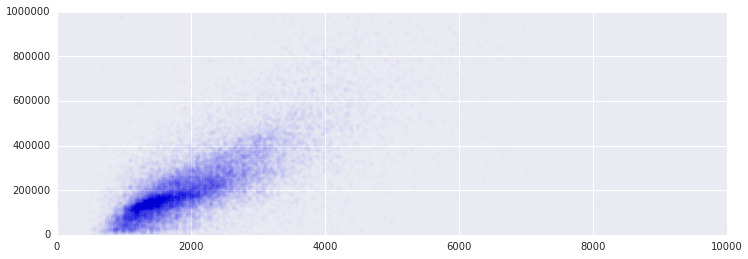

In [194]:
plt.scatter(df.floor_size, df.last_sold, alpha=0.01)
plt.xlim(0, 10000)
plt.ylim(0, 1000000)

(0, 1000000)

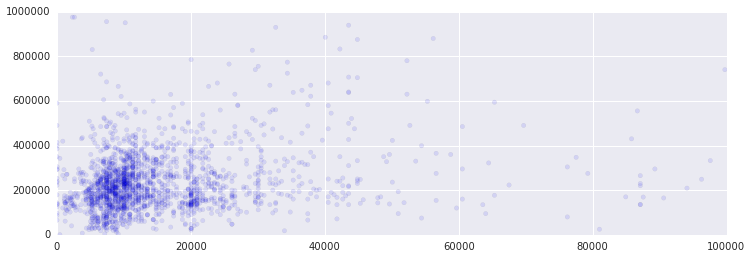

In [212]:
mydf = df[df.city == "Durham"]
plt.scatter(mydf.lot_size, mydf.last_sold, alpha=0.1)
plt.xlim(0, 100000)
plt.ylim(0, 1000000)

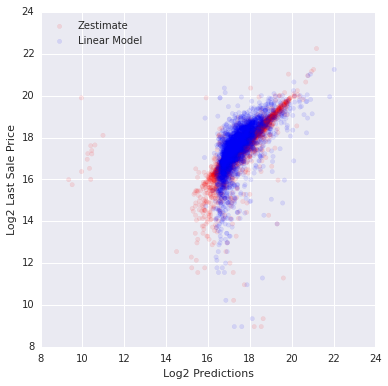

In [233]:
flsz = np.expand_dims(np.array(df.floor_size), 1)
flolsr = linear_model.LinearRegression(n_jobs=-1)
flolsr.fit(flsz[train_ixs], np.log2(df.last_sold[train_ixs]))

flolsr_preds = flolsr.predict(flsz[test_ixs])

figsize(6, 6)
plt.scatter(
    np.log2(df.zestimate[test_ixs]), np.log2(df.last_sold[test_ixs]),
    color="red", label="Zestimate", alpha=0.1)
plt.scatter(
    flolsr_preds, np.log2(df.last_sold[test_ixs]),
    color="blue", label="Linear Model", alpha=0.1)
plt.xlabel("Log2 Predictions")
plt.ylabel("Log2 Last Sale Price")
plt.xlim(8, 24)
plt.ylim(8, 24)
plt.legend(loc="upper left")
plt.show()

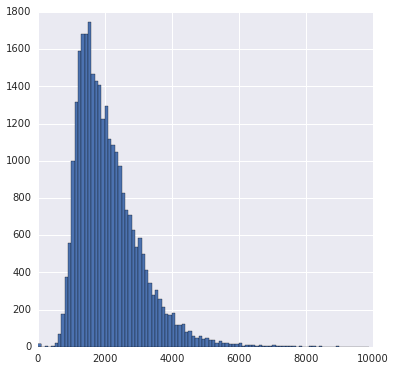

In [236]:
plt.hist(df.floor_size, bins=np.arange(0, 10000, 100))
plt.show()